# Definition of getPatch: (tensDigit, unitDigit, color=(1,0,0)) -> image 30\*60

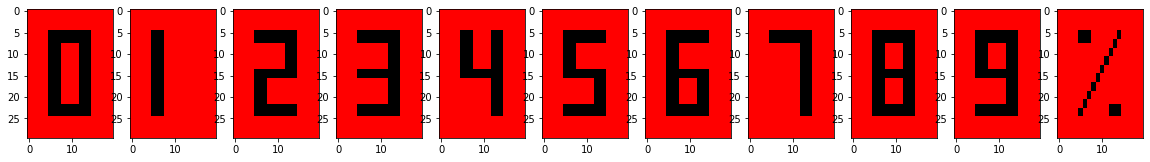

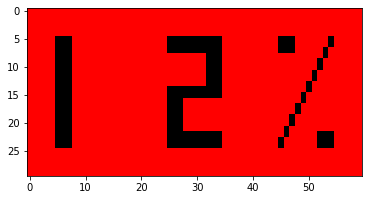

In [5]:
import re, glob, json
import cv2 # imageIO and processing
import matplotlib.pyplot as plt # show
import numpy as np

def stroke(A,L,color): # list[bool] # up, mid, down, upleft, upright, downleft, downright
    if not L:
        A[:3,:3,:] = 0,0,0
        A[-3:,-3:,:] = 0,0,0
        for i in range(10):
            A[i*2:i*2+2,10-i-1:10-i,:] = 0,0,0
    else:
        if L[0]:
            A[0:3,:,:] = 0,0,0
        if L[1]:
            A[10-1:10+1,:,:] = 0,0,0        
        if L[2]:
            A[20-3:20,:,:] = 0,0,0
        if L[3]:
            A[:10,:3,:] = 0,0,0
        if L[4]:
            A[:10,10-3:,:] = 0,0,0
        if L[5]:
            A[10:,:3,:] = 0,0,0
        if L[6]:
            A[10:,10-3:,:] = 0,0,0
    B = np.array([ [color for j in range(5+10+5)] for i in range(5+20+5) ]).astype(float)
    B[5:25,5:15,:] = A
    return B # 30,20
        
def getImg(n,color=(1,1,1)):
    A = np.array([ [color for j in range(10)] for i in range(20) ]).astype(float)
    D = {0:[1,0,1,1,1,1,1],
         1:[0,0,0,1,0,1,0],
         2:[1,1,1,0,1,1,0],
         3:[1,1,1,0,1,0,1],
         4:[0,1,0,1,1,0,1],
         5:[1,1,1,1,0,0,1],
         6:[1,1,1,1,0,1,1],
         7:[1,0,0,0,1,0,1],
         8:[1,1,1,1,1,1,1],
         9:[1,1,1,1,1,0,1],
         10:[], # percent
        }
    return stroke(A,D[n],color)
    
plt.figure(figsize=(20,5))
for i in range(11):
    plt.subplot(1,11,i+1)
    plt.imshow(getImg(i,color=(1,0,0)))
plt.show()

def getPatch(a,b,color=(1,1,1)):
    A = np.array([ [color for j in range(20+20+20)] for i in range(30) ]).astype(float)
    A[:,:20,:] = getImg(a,color)
    A[:,20:40,:] = getImg(b,color)
    A[:,40:60,:] = getImg(10,color)
    return A # 30,60
    
plt.imshow( getPatch(1,2,color=(1,0,0)) )
plt.show()

# Color and boxAny2Voc
+ voc (int): xmin,ymin,xmax,ymax
+ yolo (float): cx,cy,w,h
+ coco (int): xmin,ymin,w,h

In [6]:
color = [ (1,0,0), (0,1,0) ]

class boxAny2Voc:
    def voc(xmin,ymin,xmax,ymax,width=None,height=None):
        return int(xmin),int(ymin), int(xmax), int(ymax)
    def yoloFloat(cx,cy,w,h,width=None,height=None): # width, height only valid
        xmin = int((float(cx)-float(w)/2)*float(width))
        ymin = int((float(cy)-float(h)/2)*float(height))
        xmax = int((float(cx)+float(w)/2)*float(width))
        ymax = int((float(cy)+float(h)/2)*float(height))
        return xmin, ymin, xmax, ymax
    def yoloInt(cx,cy,w,h,width=None,height=None):
        xmin = int(int(cx)-int(w)/2)
        ymin = int(int(cy)-int(h)/2)
        xmax = int(int(cx)+int(w)/2)
        ymax = int(int(cy)+int(h)/2)
        return xmin, ymin, xmax, ymax
    def coco(xmin,ymin,w,h,width=None,height=None):
        return int(xmin), int(ymin), int(xmin)+int(w), int(ymin)+int(h)

# Plot Object Detection
+ Ground truth: yoloFloat, Voc, Coco
+ Prediction: yoloFloat, yoloInt, Voc, Coco

In [7]:
def getAnnot(imgPath, annotPath, classList):
    if ".xml" in annotPath: # Pascal VOC
        xml = open(annotPath,"r").read()
        nameL = re.findall("<name>(.*)</name>",xml)
        xminL = re.findall("<xmin>(.*)</xmin>",xml)
        yminL = re.findall("<ymin>(.*)</ymin>",xml)
        xmaxL = re.findall("<xmax>(.*)</xmax>",xml)
        ymaxL = re.findall("<ymax>(.*)</ymax>",xml)
        boxes, cids = [], []        
        for name,xmin,ymin,xmax,ymax in zip(nameL,xminL,yminL,xmaxL,ymaxL):
            cids.append( classList.index(name) )
            xmin, ymin, xmax, ymax = boxAny2Voc.voc(xmin,ymin,xmax,ymax)
            boxes.append( [xmin, ymin, xmax, ymax] )
        return boxes, cids
    elif ".txt" in annotPath: # YOLO
        height, width, _ = cv2.imread(imgPath).shape
        boxes, cids = [], []
        for line in open(annotPath,"r").readlines():
            cid, cx, cy, w, h = line.split(" ")
            cids.append( int(cid) )
            if "." in cx:
                xmin, ymin, xmax, ymax = boxAny2Voc.yoloFloat(cx, cy, w, h, width, height)
            else:
                xmin, ymin, xmax, ymax = boxAny2Voc.yoloInt(cx, cy, w, h)
            boxes.append( [xmin, ymin, xmax, ymax] )
        return boxes, cids
    elif ".json" in annotPath: # COCO
        D = json.load( open(annotPath,"r") )
        imgName   = imgPath.split('/')[-1]
        imgDict   = list(filter(lambda d:d["file_name"]==imgName,D["images"]))[0]
        id        = imgDict["id"]
        annotDict = list(filter(lambda d:d["image_id"]==id,D["annotations"]))
        boxes, cids = [], []
        for d in annotDict:
            cid = d['category_id']-1
            cids.append( cid )
            xmin, ymin, w, h = d['bbox']
            xmin, ymin, xmax, ymax = boxAny2Voc.coco(xmin, ymin, w, h) 
            boxes.append( [xmin, ymin ,xmax, ymax] )
        return boxes, cids
    else:
        raise ValueError("Annotation not found")

def show(imgPath, annotPath, boxesTypePD, boxesPD, cidsPD, cfsPD, classList, valueRatios=(1,1)):
    imgRaw = cv2.imread(imgPath)[:,:,::-1]/255

    if not annotPath:
        imgGT = np.zeros((imgRaw.shape[0],imgRaw.shape[1],3))
    else:
        imgGT = imgRaw.copy()
        boxesGT, cidsGT = getAnnot(imgPath,annotPath,classList) # boxesType, boxes, cids
        for (xmin,ymin,xmax,ymax),cid in zip(boxesGT,cidsGT):
            imgGT[ymin-4:ymin+4,xmin:xmax,:] = color[cid]
            imgGT[ymax-4:ymax+4,xmin:xmax,:] = color[cid]
            imgGT[ymin:ymax,xmin-4:xmin+4,:] = color[cid]
            imgGT[ymin:ymax,xmax-4:xmax+4,:] = color[cid]
        
    if not boxesTypePD:
        imgPD = np.zeros((imgRaw.shape[0],imgRaw.shape[1],3))
    else:
        imgPD = imgRaw.copy()
        height, width, _ = imgPD.shape
        for i,(b1,b2,b3,b4) in enumerate(boxesPD):
            xmin, ymin, xmax, ymax = getattr(boxAny2Voc,boxesTypePD)(b1,b2,b3,b4,width,height)
            imgPD[ymin-4:ymin+4,xmin:xmax,:] = color[cidsPD[i]]
            imgPD[ymax-4:ymax+4,xmin:xmax,:] = color[cidsPD[i]]
            imgPD[ymin:ymax,xmin-4:xmin+4,:] = color[cidsPD[i]]
            imgPD[ymin:ymax,xmax-4:xmax+4,:] = color[cidsPD[i]]
            # percentage patches
            ud, td = int(cfsPD[i]*10), int(cfsPD[i]*100)%10
            P = getPatch(ud,td,color=color[cidsPD[i]])
            (ph, pw, _), (rh,rw) = P.shape, valueRatios
            P = cv2.resize( P, (int(pw*rw),int(ph*rh)) )
            if ymin>=P.shape[0]: # upper bar
                imgPD[ymin-P.shape[0]:ymin,xmin:xmin+P.shape[1],:] = P
            elif ymax+P.shape[0]<imgPD.shape[0]: # down bar
                imgPD[ymax:ymax+P.shape[0],xmin:xmin+P.shape[1],:] = P

    fig = plt.figure(figsize=(40,10))
    fig.set_facecolor("white")
    plt.subplot(1,3,1)
    plt.title("raw", fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.imshow(imgRaw)
    
    plt.subplot(1,3,2)
    plt.title("GT", fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=16)
    for r,g,b in color:
        c2hex = lambda c: ("0" if c<=1/16 else '') + hex(int(c*255))[2:]
        plt.scatter([0],[0],c=f"#{c2hex(r)}{c2hex(g)}{c2hex(b)}")
    plt.legend(labels=classList, fontsize=16)
    plt.imshow(imgGT)
    
    plt.subplot(1,3,3)
    plt.title("Pred", fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=16)
    for r,g,b in color:
        c2hex = lambda c: ("0" if c<=1/16 else '') + hex(int(c*255))[2:]
        plt.scatter([0],[0],c=f"#{c2hex(r)}{c2hex(g)}{c2hex(b)}")
    plt.legend(labels=classList, fontsize=16)
    plt.imshow(imgPD)
    plt.show()

GT: yoloFloat, Pred:yoloFloat


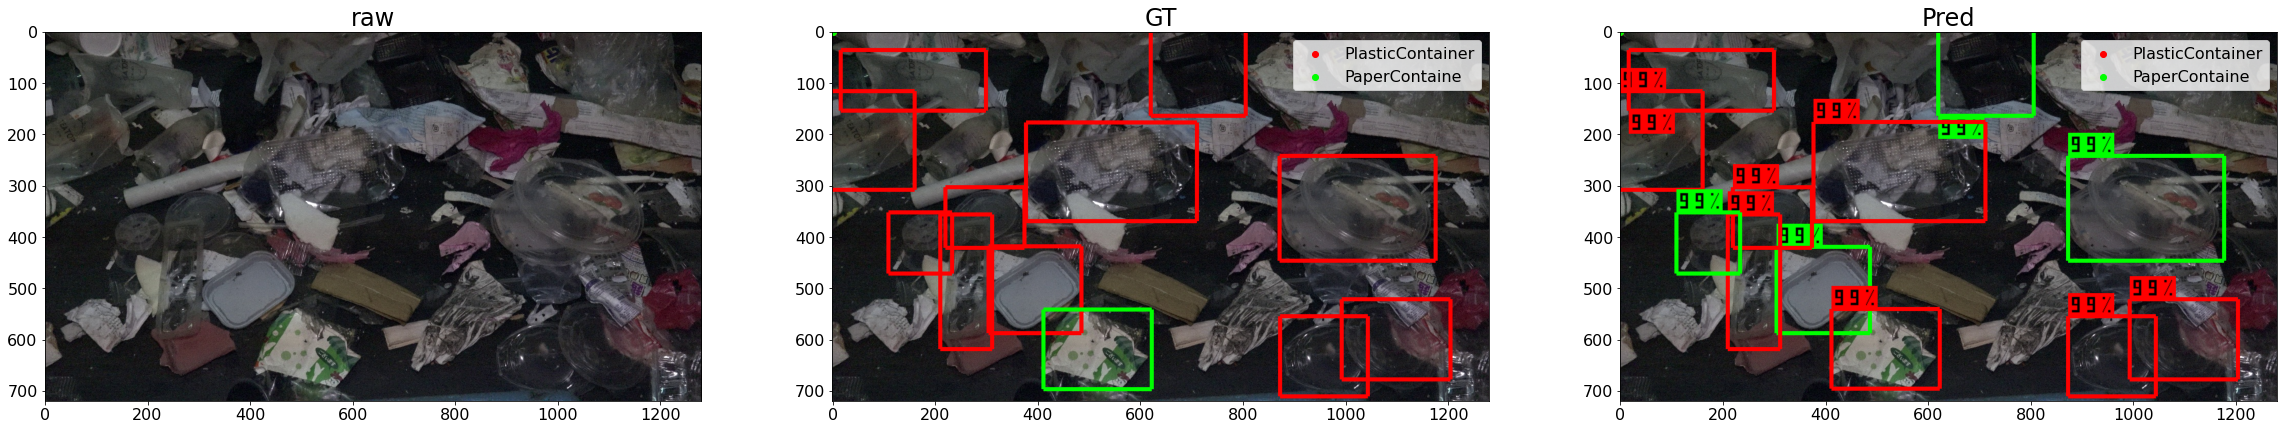

GT: yoloFloat, Pred:yoloInt


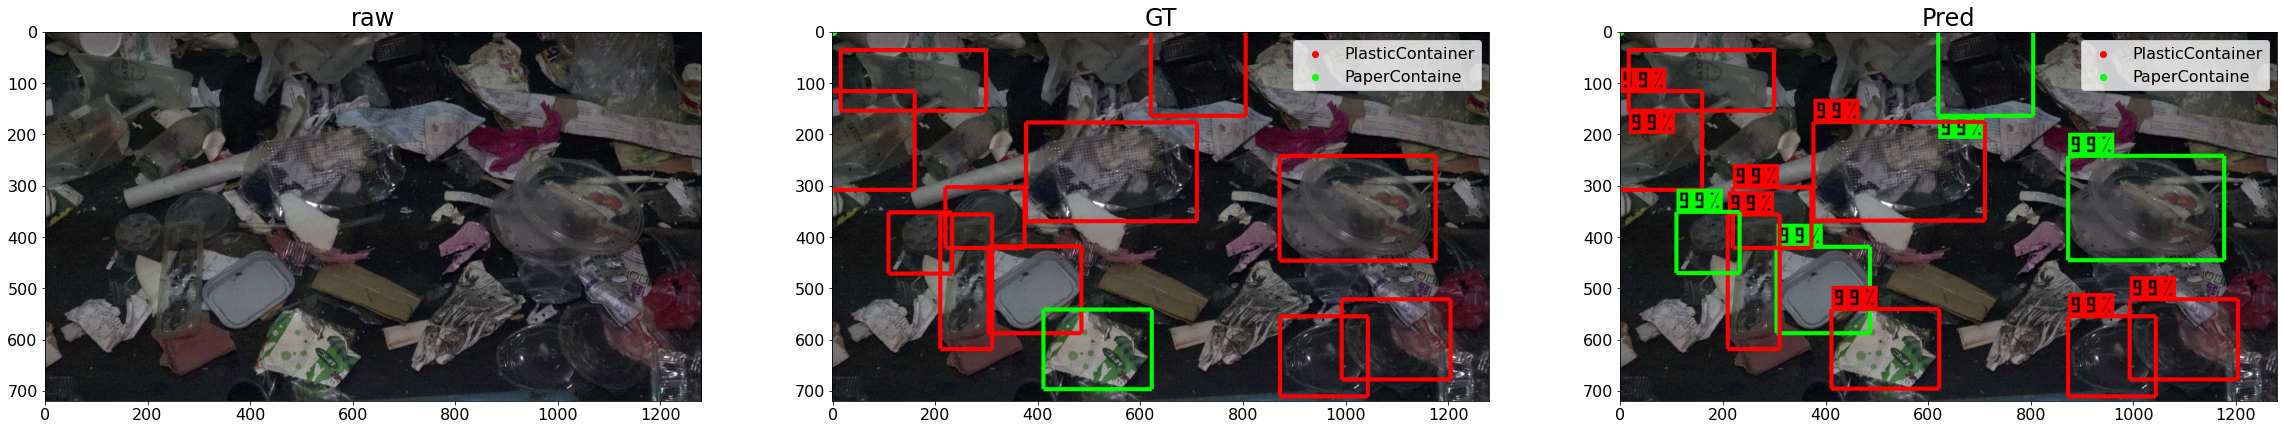

GT: yoloFloat, Pred:voc


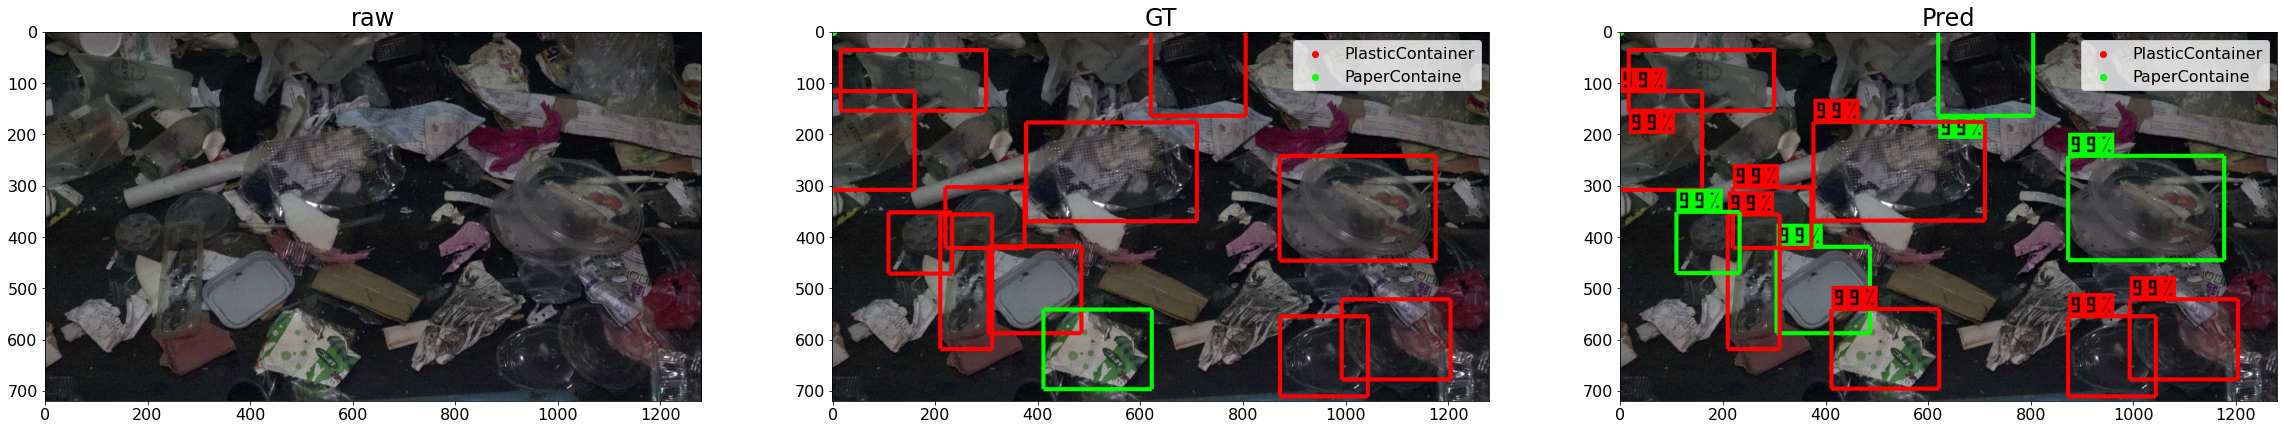

GT: yoloFloat, Pred:Coco


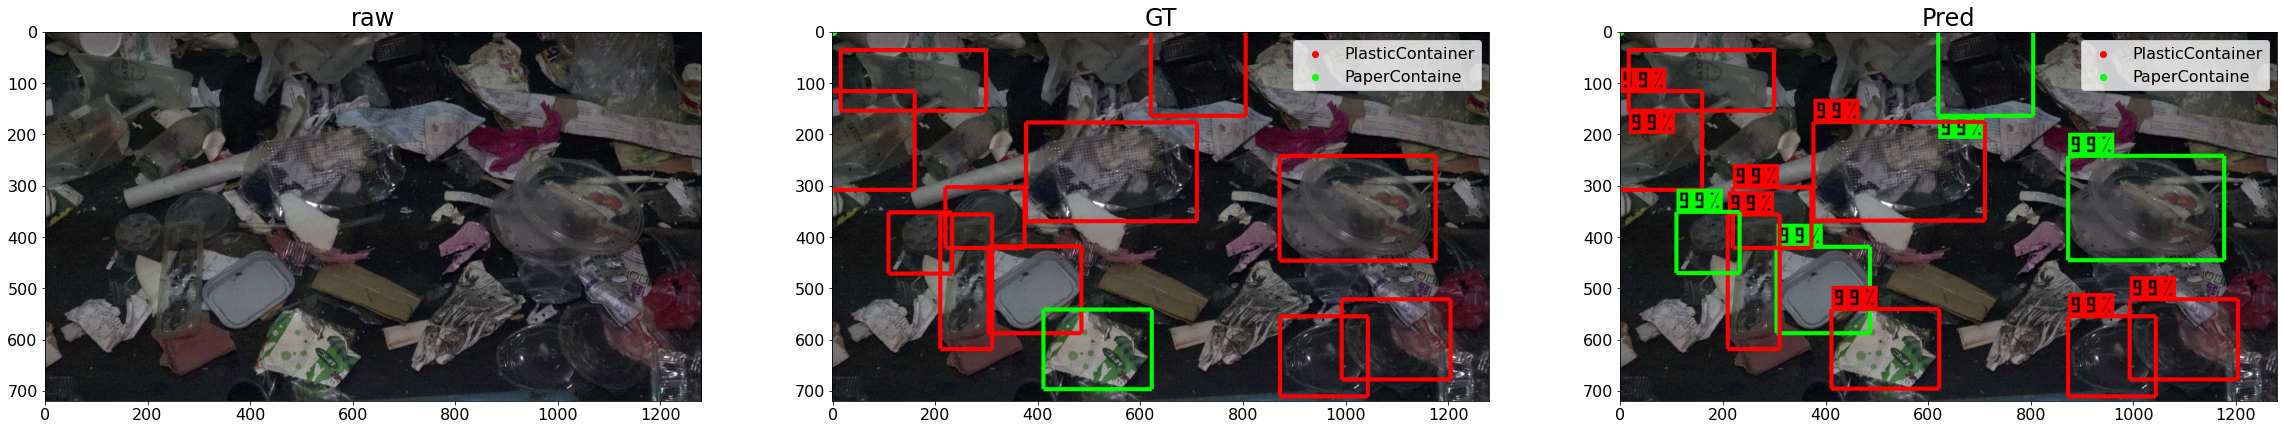

----------------------------------------------------------------------------------------------------

GT: voc, Pred:yoloFloat


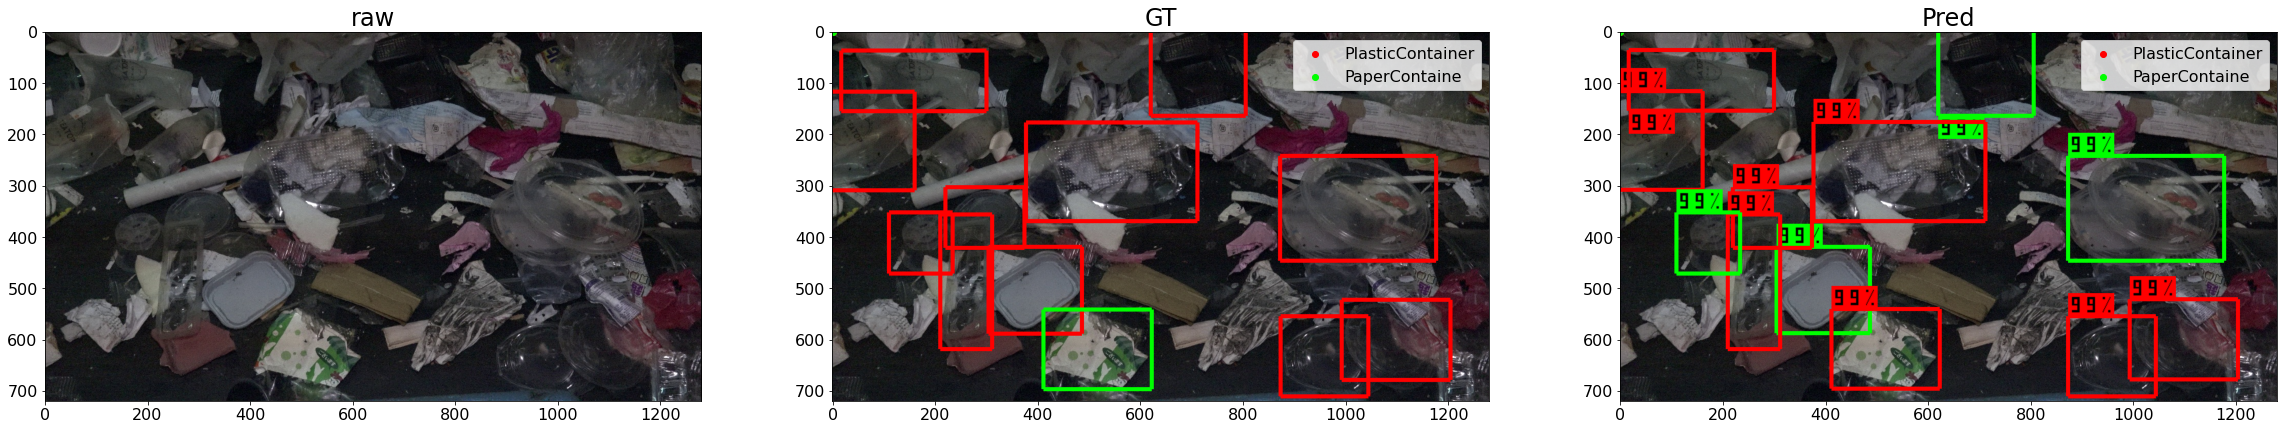

GT: coco, Pred:yoloFloat


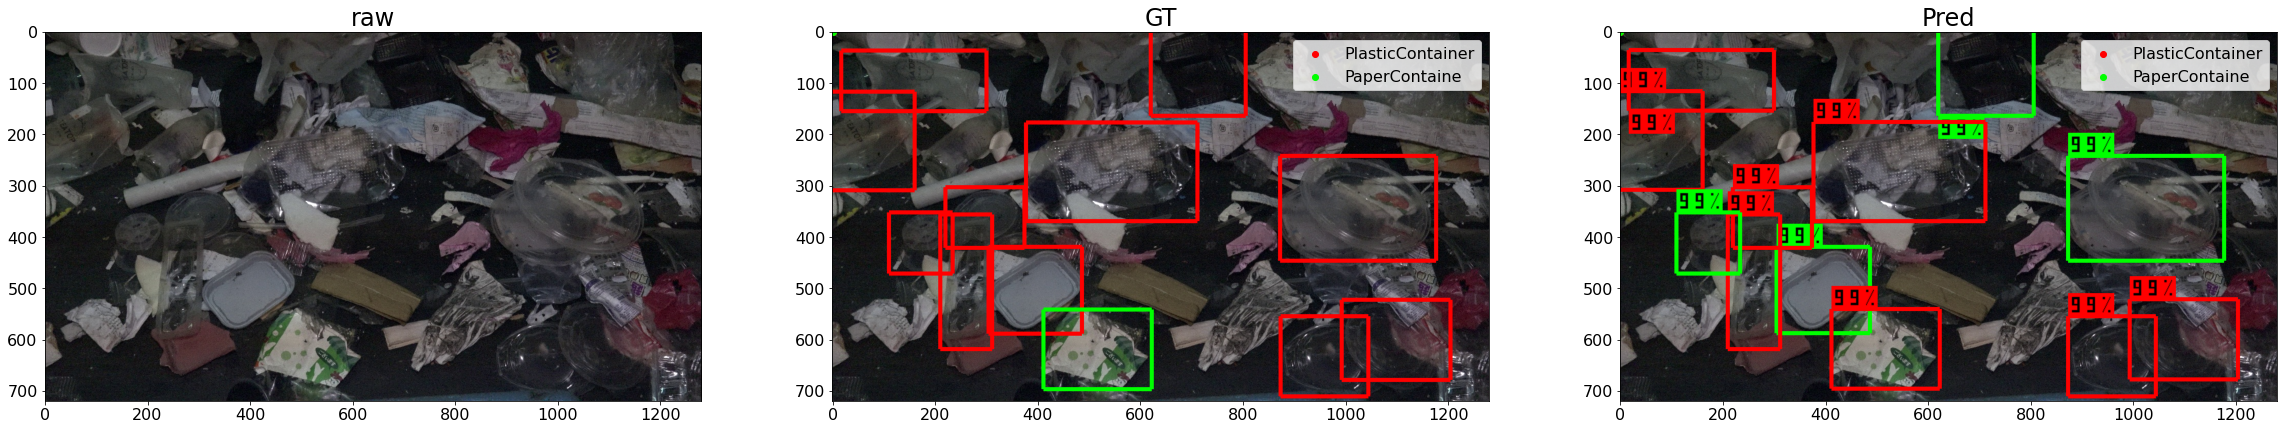

In [8]:
"""
+ Ground truth: yoloFloat, Voc, Coco
+ Prediction: yoloFloat, yoloInt, Voc, Coco
Testing order: (GT,PD)=[(YF,YF), (YF,YI), (YF,Voc), (YF,Coco), (Voc,YF), (Coco,YF)]
"""

boxesYoloFloat = [[0.3094, 0.7007, 0.1422, 0.2347], [0.8008, 0.4792, 0.2375, 0.2833], [0.8586, 0.8347, 0.1656, 0.2167],
                  [0.0629, 0.2972, 0.1258, 0.2667], [0.2328, 0.5042, 0.1203, 0.1639], [0.1246, 0.1347, 0.2211, 0.1639],
                  [0.7496, 0.8792, 0.1336, 0.2167], [0.5573, 0.1169, 0.1449, 0.2250], [0.4256, 0.3804, 0.2614, 0.2675],
                  [0.4046, 0.8599, 0.1648, 0.2155], [0.2043, 0.6779, 0.0791, 0.3640], [0.1348, 0.5735, 0.0968, 0.1656]]
boxesYoloInt = [[ 396,  504,  182,  168], [1025,  345,  304,  203], [1099,  600,  211,  156],
                [  80,  213,  161,  192], [ 297,  363,  153,  118], [ 159,   96,  283,  118],
                [ 959,  633,  171,  156], [ 713,   84,  185,  162], [ 544,  273,  334,  192],
                [ 517,  619,  210,  155], [ 261,  488,  101,  262], [ 172,  412,  123,  119]]
boxesVoc = [[305, 420, 487, 588], [873, 243, 1177, 446], [993, 522, 1204, 678],
            [0, 117, 160, 309,], [220, 304, 373, 422], [17, 37, 300, 155],
            [873, 555, 1044, 711], [620, 3, 805, 165], [377, 177, 711, 369],
            [412, 541, 622, 696], [210, 357, 311, 619], [110, 352, 233, 471]]
boxesCoco = [[305, 420, 182, 168], [873, 243, 304, 203], [993, 522, 211, 156],
             [  0, 117, 160, 192], [220, 304, 153, 118], [ 17,  37, 283, 118],
             [873, 555, 171, 156], [620,   3, 185, 162], [377, 177, 334, 192],
             [412, 541, 210, 155], [210, 357, 101, 262], [110, 352, 123, 119]]

cids = [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
cfs = [0.99 for i in range(12)]

print("GT: yoloFloat, Pred:yoloFloat")
show("./C0025_00505.jpg","./C0025_00505.txt","yoloFloat",boxesYoloFloat,cids,cfs,["PlasticContainer","PaperContaine"],(1.5,1.5))

print("GT: yoloFloat, Pred:yoloInt")
show("./C0025_00505.jpg","./C0025_00505.txt","yoloInt",boxesYoloInt,cids,cfs,["PlasticContainer","PaperContaine"],(1.5,1.5))

print("GT: yoloFloat, Pred:voc")
show("./C0025_00505.jpg","./C0025_00505.txt","voc",boxesVoc,cids,cfs,["PlasticContainer","PaperContaine"],(1.5,1.5))

print("GT: yoloFloat, Pred:Coco")
show("./C0025_00505.jpg","./C0025_00505.txt","coco",boxesCoco,cids,cfs,["PlasticContainer","PaperContaine"],(1.5,1.5))

print("-"*100+"\n")

print("GT: voc, Pred:yoloFloat")
show("./C0025_00505.jpg","./C0025_00505.xml","yoloFloat",boxesYoloFloat,cids,cfs,["PlasticContainer","PaperContaine"],(1.5,1.5))

print("GT: coco, Pred:yoloFloat")
show("./C0025_00505.jpg","./labels.json","yoloFloat",boxesYoloFloat,cids,cfs,["PlasticContainer","PaperContaine"],(1.5,1.5))

In [1]:
def IOU(boxA, boxB): # VOC
    (xminA, yminA, xmaxA, ymaxA), (xminB, yminB, xmaxB, ymaxB) = boxA, boxB
    inter = max(0,min(ymaxA,ymaxB)-max(yminA,yminB)) * max(0,min(xmaxA,xmaxB)-max(xminA,xminB))
    areaA = (ymaxA-yminA) * (xmaxA-xminA)
    areaB = (ymaxB-yminB) * (xmaxB-xminB)
    return inter / (areaA+areaB-inter)

def NMS(bboxes, cids, cfs, boxesType="yoloFloat", threshold=0.3):
    bboxes, cids, cfs = np.array(bboxes), np.array(cids), np.array(cfs)
    nmsBoxes, nmsCIDs, nmsCFs = [], [], []
    while len(bboxes)>=2:
        nmsBoxes.append( bboxes[0] )
        nmsCIDs.append( cids[0] )
        nmsCFs.append( cfs[0] )
        boxA = getattr(boxAny2Voc,boxesType)(bboxes[0][0], bboxes[0][1], bboxes[0][2], bboxes[0][3], width=1000, height=1000)
        bboxes, cids, cfs = bboxes[1:], cids[1:], cfs[1:]
        keepI = []
        for i,box in enumerate(bboxes):
            boxB = getattr(boxAny2Voc,boxesType)(box[0], box[1], box[2], box[3], width=1000, height=1000)
            iou  = IOU(boxA,boxB)
            if iou<threshold:
                keepI.append(i)
        bboxes = bboxes[keepI]
        cids = cids[keepI]
        cfs = cfs[keepI]
    return nmsBoxes, nmsCIDs, nmsCFs